In [1]:
import cv2
import os
import sys
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

from skimage.transform import resize
import os
from os.path import join
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
from keras.models import Sequential,Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D

Using TensorFlow backend.


In [3]:
def plot_history(history):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,7))
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='upper left')
    
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')

In [4]:
#(545, 535, 3) исходное
IMG_SIZE = (197,197,3) #REznet FIGSIZE
#IMG_SIZE = (224,224,3)
# IMG_SIZE = (125,125,3)

In [5]:
# img = cv2.imread('./data/all_ica_img/'+file_names[117])
# plt.imshow(img)
# plt.show()
# plt.imshow(img[25:570, 185:720])

In [6]:
# img = cv2.imread('./data/all_ica_img/'+file_names[0])
# images = [cv2.imread('./data/all_ica_img/'+file_name)
#                         for file_name in file_names]

In [7]:
file_names = sorted(os.listdir('./data/all_ica_img/'))[:]

X = np.array([resize(cv2.imread(join('./data/all_ica_img/', file_name))[25:570, 185:720], IMG_SIZE, mode='reflect')
              for file_name in file_names[:]]).astype(np.float32)
y = np.array([file_name.split('.')[0].split('_')[-1] for file_name in file_names[:]]).astype(int)



In [8]:
print (np.unique(y, return_counts=True))

(array([0, 1]), array([1700, 5541], dtype=int64))


In [8]:
X_majority = X[y==1]
X_minority = X[y==0]
X_majority_downsampled = resample(X_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1700,     # to match minority class
                                 random_state=123)
X = np.concatenate((X_minority,X_majority_downsampled),axis=0)
y = np.zeros(1700*2)
y[1700:]=1
del X_majority
del X_minority
del X_majority_downsampled

In [9]:
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# path = './data/train_test/train/'
# file_names = sorted(os.listdir(path))
# X_train = [resize(cv2.imread(join(path, file_name))[25:570, 185:720], IMG_SIZE, mode='reflect')
#               for file_name in file_names]
# y_train = [file_name.split('.')[0].split('_')[-1] for file_name in file_names]

# X_train = np.array(X_train).astype(np.float32)
# y_train = np.array(y_train).astype(int)
# y_train = to_categorical(y_train)



# path = './data/train_test/test/'
# file_names = sorted(os.listdir(path))
# X_test = [resize(cv2.imread(join(path, file_name))[25:570, 185:720], IMG_SIZE, mode='reflect')
#               for file_name in file_names]
# y_test = [file_name.split('.')[0].split('_')[-1] for file_name in file_names]

# X_test = np.array(X_test).astype(np.float32)
# X_test = np.array(X_test).astype(int)
# y_test = to_categorical(y_test)

### аугментация

In [12]:
# datagen = ImageDataGenerator(rotation_range=10,
#                                      width_shift_range=0.1,
#                                      height_shift_range=0.1,
#                                      horizontal_flip=True)

# model.fit_generator(datagen.flow(X_train,y_train,batch_size=128), steps_per_epoch=len(X_train) / 128,
#                     epochs=20,
#                     verbose=1, 
#                     validation_data=(X_test, y_test))

In [13]:
from keras.applications.xception import Xception

def get_Xception():
    basemodel = Xception(include_top=False, input_shape=IMG_SIZE, pooling='avg')
    base_out = basemodel.output

    base_out = Dense(2048, activation='elu',
                           kernel_initializer='glorot_normal',
                           kernel_regularizer=l2(1e-3))(base_out)

    base_out = Dropout(0.5)(base_out)

    base_out = Dense(1024, activation='relu',
                           kernel_initializer='glorot_normal',
                           kernel_regularizer=l2(1e-3))(base_out)

    predictions = Dense(2, activation='softmax',
                              kernel_initializer='glorot_normal',
                              kernel_regularizer=l2(1e-3))(base_out)

    model = Model(inputs=basemodel.input, outputs=predictions)
    trainable_border = 107  # 141
    for layer in model.layers[:trainable_border]:
            layer.trainable = False
    for layer in model.layers[trainable_border:]:
            layer.trainable = True

    model.compile(optimizer=Adam(lr=1e-3), #, decay=1e-2
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])        
    return model

In [14]:
model = get_Xception()
history = model.fit(X_train, y_train, batch_size=64, epochs=150,
          verbose=1, validation_data=(X_test, y_test))

Train on 2380 samples, validate on 1020 samples
Epoch 1/150
2380/2380 [==============================] - 42s 18ms/step - loss: 2.5293 - acc: 0.5101 - val_loss: 1.6326 - val_acc: 0.4863
Epoch 2/150
2380/2380 [==============================] - 33s 14ms/step - loss: 1.2322 - acc: 0.4954 - val_loss: 0.9558 - val_acc: 0.4863
Epoch 3/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.8542 - acc: 0.5059 - val_loss: 0.7807 - val_acc: 0.4863
Epoch 4/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.7502 - acc: 0.4857 - val_loss: 0.7272 - val_acc: 0.4863
Epoch 5/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.7169 - acc: 0.4803 - val_loss: 0.7086 - val_acc: 0.4863
Epoch 6/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.7044 - acc: 0.4945 - val_loss: 0.7011 - val_acc: 0.4863
Epoch 7/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.6993 - acc: 0.5059 - val_loss: 0.6979 - val_acc: 

2380/2380 [==============================] - 33s 14ms/step - loss: 0.6931 - acc: 0.5059 - val_loss: 0.6937 - val_acc: 0.4863
Epoch 61/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.6932 - acc: 0.5059 - val_loss: 0.6937 - val_acc: 0.4863
Epoch 62/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.6932 - acc: 0.5059 - val_loss: 0.6937 - val_acc: 0.4863
Epoch 63/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.6931 - acc: 0.5059 - val_loss: 0.6935 - val_acc: 0.4863
Epoch 64/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.6931 - acc: 0.5059 - val_loss: 0.6936 - val_acc: 0.4863
Epoch 65/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.6932 - acc: 0.5059 - val_loss: 0.6936 - val_acc: 0.4863
Epoch 66/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.6931 - acc: 0.5059 - val_loss: 0.6936 - val_acc: 0.4863
Epoch 67/150
2380/2380 [=======================

2380/2380 [==============================] - 33s 14ms/step - loss: 0.6931 - acc: 0.5059 - val_loss: 0.6936 - val_acc: 0.4863
Epoch 120/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.6931 - acc: 0.5059 - val_loss: 0.6935 - val_acc: 0.4863
Epoch 121/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.6931 - acc: 0.5059 - val_loss: 0.6936 - val_acc: 0.4863
Epoch 122/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.6931 - acc: 0.5059 - val_loss: 0.6937 - val_acc: 0.4863
Epoch 123/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.6931 - acc: 0.5059 - val_loss: 0.6937 - val_acc: 0.4863
Epoch 124/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.6931 - acc: 0.5059 - val_loss: 0.6937 - val_acc: 0.4863
Epoch 125/150
2380/2380 [==============================] - 33s 14ms/step - loss: 0.6931 - acc: 0.5059 - val_loss: 0.6938 - val_acc: 0.4863
Epoch 126/150
2380/2380 [================

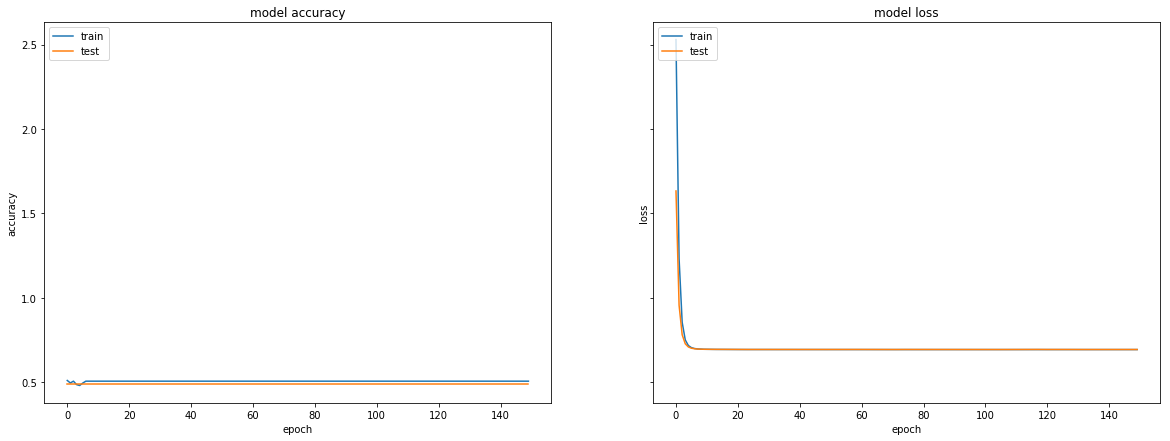

In [15]:
plot_history(history)

In [17]:
from keras.applications.resnet50 import ResNet50
def get_ResNet():
    basemodel = ResNet50(include_top=False, input_shape=IMG_SIZE)
    base_out = basemodel.output

    base_out = Flatten()(base_out)

    base_out = Dense(1024, activation='elu',
                           kernel_initializer='glorot_normal',
                           kernel_regularizer=l2(1e-3))(base_out)
    base_out = Dropout(0.5)(base_out)
    predictions = Dense(2, activation='softmax',
                              kernel_initializer='glorot_normal',
                              kernel_regularizer=l2(1e-3))(base_out)
    model = Model(inputs=basemodel.input, outputs=predictions)

    for layer in model.layers[:141]:
                layer.trainable = False
    for layer in model.layers[141:]:
                layer.trainable = True

    model.compile(optimizer=Adam(lr=1e-4, decay=1e-2),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    return model

#
    # model = ResNet50(include_top=False,input_shape = IMG_SIZE)
    # for layer in model.layers[:141]:
    #             layer.trainable = False
    # for layer in model.layers[141:]:
    #             layer.trainable = True       
    # last = model.layers[-1].output
    # x = Dense(2, activation="softmax")(last)
    # finetuned_model = Model(model.input, x)
    # finetuned_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    # history = finetuned_model.fit(X_train, y_train, batch_size=128, epochs=10,
    #           verbose=1, validation_data=(X_test, y_test))

In [18]:
model = get_ResNet()
history = model.fit(X_train, y_train, batch_size=64, epochs=150,
          verbose=1, validation_data=(X_test, y_test))

Train on 2380 samples, validate on 1020 samples
Epoch 1/150
2380/2380 [==============================] - 37s 15ms/step - loss: 1.7360 - acc: 0.6517 - val_loss: 1.9354 - val_acc: 0.4863
Epoch 2/150
2380/2380 [==============================] - 31s 13ms/step - loss: 1.4397 - acc: 0.8181 - val_loss: 1.8544 - val_acc: 0.4863
Epoch 3/150
2380/2380 [==============================] - 31s 13ms/step - loss: 1.2483 - acc: 0.9151 - val_loss: 1.9079 - val_acc: 0.4863
Epoch 4/150
2380/2380 [==============================] - 31s 13ms/step - loss: 1.0948 - acc: 0.9819 - val_loss: 2.2047 - val_acc: 0.4863
Epoch 5/150
2380/2380 [==============================] - 31s 13ms/step - loss: 1.0339 - acc: 0.9941 - val_loss: 2.2019 - val_acc: 0.4863
Epoch 6/150
2380/2380 [==============================] - 31s 13ms/step - loss: 1.0040 - acc: 0.9966 - val_loss: 2.1433 - val_acc: 0.4863
Epoch 7/150
2380/2380 [==============================] - 31s 13ms/step - loss: 0.9856 - acc: 0.9987 - val_loss: 2.1849 - val_acc: 

Epoch 59/150
2380/2380 [==============================] - 31s 13ms/step - loss: 0.7498 - acc: 1.0000 - val_loss: 1.8332 - val_acc: 0.4863
Epoch 60/150
2380/2380 [==============================] - 31s 13ms/step - loss: 0.7475 - acc: 0.9996 - val_loss: 1.8160 - val_acc: 0.4863
Epoch 61/150
2380/2380 [==============================] - 31s 13ms/step - loss: 0.7456 - acc: 0.9996 - val_loss: 1.8060 - val_acc: 0.4863
Epoch 62/150
2380/2380 [==============================] - 31s 13ms/step - loss: 0.7424 - acc: 1.0000 - val_loss: 1.7684 - val_acc: 0.4863
Epoch 63/150
2380/2380 [==============================] - 31s 13ms/step - loss: 0.7395 - acc: 1.0000 - val_loss: 1.8054 - val_acc: 0.4863
Epoch 64/150
2380/2380 [==============================] - 31s 13ms/step - loss: 0.7367 - acc: 1.0000 - val_loss: 1.7927 - val_acc: 0.4863
Epoch 65/150
2380/2380 [==============================] - 31s 13ms/step - loss: 0.7343 - acc: 1.0000 - val_loss: 1.8007 - val_acc: 0.4863
Epoch 66/150
2380/2380 [==========

2380/2380 [==============================] - 31s 13ms/step - loss: 0.6159 - acc: 1.0000 - val_loss: 1.7034 - val_acc: 0.4863
Epoch 119/150
2380/2380 [==============================] - 31s 13ms/step - loss: 0.6140 - acc: 1.0000 - val_loss: 1.7065 - val_acc: 0.4863
Epoch 120/150
2380/2380 [==============================] - 31s 13ms/step - loss: 0.6120 - acc: 1.0000 - val_loss: 1.7222 - val_acc: 0.4863
Epoch 121/150
2380/2380 [==============================] - 31s 13ms/step - loss: 0.6101 - acc: 1.0000 - val_loss: 1.7141 - val_acc: 0.4863
Epoch 122/150
2380/2380 [==============================] - 31s 13ms/step - loss: 0.6081 - acc: 1.0000 - val_loss: 1.7004 - val_acc: 0.4863
Epoch 123/150
2380/2380 [==============================] - 31s 13ms/step - loss: 0.6067 - acc: 0.9996 - val_loss: 1.7207 - val_acc: 0.4863
Epoch 124/150
2380/2380 [==============================] - 31s 13ms/step - loss: 0.6061 - acc: 0.9996 - val_loss: 1.7496 - val_acc: 0.4863
Epoch 125/150
2380/2380 [================

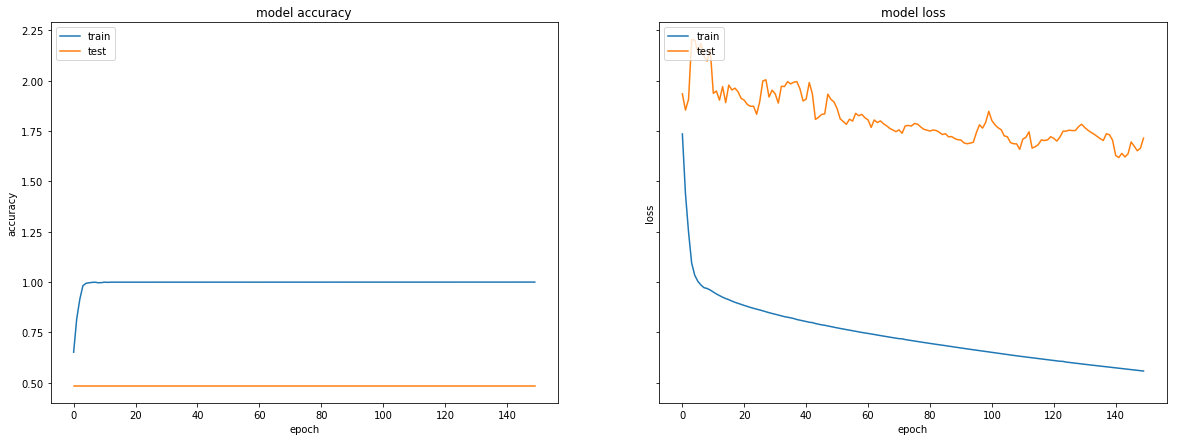

In [19]:
plot_history(history)

In [ ]:
from keras import applications
def get_VGG16():
    model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (IMG_SIZE))
    for layer in model.layers[:5]:
        layer.trainable = False
    x = model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(2, activation="softmax")(x)
    model_final = Model(inputs = model.input, outputs = predictions)
    model_final.compile(loss = "categorical_crossentropy", optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
    return model_final

In [ ]:
model = get_VGG16()
history = model.fit(X_train, y_train, batch_size=64, epochs=150,
          verbose=1, validation_data=(X_test, y_test))

Train on 2380 samples, validate on 1020 samples
Epoch 1/150
2380/2380 [==============================] - 73s 31ms/step - loss: 0.7092 - acc: 0.5639 - val_loss: 0.6237 - val_acc: 0.6471
Epoch 2/150
2380/2380 [==============================] - 61s 26ms/step - loss: 0.6456 - acc: 0.6256 - val_loss: 0.5991 - val_acc: 0.6490
Epoch 3/150
2380/2380 [==============================] - 60s 25ms/step - loss: 0.6275 - acc: 0.6534 - val_loss: 0.5946 - val_acc: 0.6706
Epoch 4/150
2380/2380 [==============================] - 60s 25ms/step - loss: 0.6055 - acc: 0.6807 - val_loss: 0.5905 - val_acc: 0.6716
Epoch 5/150
2380/2380 [==============================] - 59s 25ms/step - loss: 0.6024 - acc: 0.6756 - val_loss: 0.5873 - val_acc: 0.6824
Epoch 6/150
2380/2380 [==============================] - 61s 26ms/step - loss: 0.5899 - acc: 0.6920 - val_loss: 0.6057 - val_acc: 0.6804
Epoch 7/150
2380/2380 [==============================] - 61s 26ms/step - loss: 0.5872 - acc: 0.7021 - val_loss: 0.5752 - val_acc: 

In [ ]:
plot_history(history)

## 2

In [ ]:
from keras.layers import Lambda,GlobalAveragePooling2D
def ConvBlock(model, layers, filters):
    '''Create [layers] layers consisting of zero padding, a convolution with [filters] 3x3 filters and batch normalization. Perform max pooling after the last layer.'''
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Conv2D(filters, (3, 3), activation='relu'))
        model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def create_model():
    '''Create the FCN and return a keras model.'''

    model = Sequential()

    # Input image: 75x75x3
    model.add(Lambda(lambda x: x, input_shape=IMG_SIZE))
    ConvBlock(model, 1, 32)
    # 37x37x32
    ConvBlock(model, 1, 64)
    # 18x18x64
    ConvBlock(model, 1, 128)
    # 9x9x128
    ConvBlock(model, 1, 128)
    # 4x4x128
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(2, (3, 3), activation='relu'))
    model.add(GlobalAveragePooling2D())
    # 4x4x2
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

    return model


In [ ]:
model = create_model()
history = model.fit(X_train, y_train, batch_size=32, epochs=150,
          verbose=1, validation_data=(X_test, y_test))

In [ ]:
plot_history(history)

## 3

In [ ]:
def getModel():
    #Build keras model
    
    model=Sequential()
    
    # CNN 1
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=IMG_SIZE))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #CNN 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # You must flatten the data for the dense layers
    model.add(Flatten())

    #Dense 1
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

model = getModel()
# batch_size = 32
# earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
# mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

history = model.fit(X_train, y_train[:,1], batch_size=64, epochs=150,
          verbose=1, validation_data=(X_test, y_test[:,1]))

In [ ]:
plot_history(history)

## 4

In [ ]:
def get_model_notebook( relu_type='relu'):
    # angle variable defines if we should use angle parameter or ignore it
    input_1 = Input(shape=IMG_SIZE)

    fcnn = Conv2D(32, kernel_size=(3, 3), activation=relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    local_input = input_1
    partial_model = Model(input_1, fcnn)
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    # For some reason i've decided not to normalize angle data
    output = Dense(1, activation="sigmoid")(dense)
    model = Model(local_input, output)
    optimizer = Adam(lr=0.001, decay=0.001)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model #, partial_model

In [ ]:
model = get_model_notebook()
history = model.fit(X_train, y_train[:,1], batch_size=64, epochs=150,
          verbose=1, validation_data=(X_test, y_test[:,1]))

In [ ]:
plot_history(history)

In [ ]:
def LeNet_model():
    model = Sequential()

    model.add(Conv2D(6, (5, 5), input_shape = IMG_SIZE))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation("sigmoid"))

    model.add(Conv2D(16, (3, 3), padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation("sigmoid"))

    model.add(Conv2D(120, (1, 1), padding='valid'))

    model.add(Flatten())
    model.add(Dense(200))
    model.add(Activation("sigmoid"))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())
    return model

In [ ]:
model = LeNet_model()
history = model.fit(X_train, y_train, batch_size=32, epochs=200,
          verbose=1, validation_data=(X_test, y_test))

In [ ]:
plot_history(history)

## 1

In [ ]:
from keras.layers import Input, GlobalMaxPooling2D, concatenate, Concatenate
from keras.applications import VGG16
def getVggAngleModel():

    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=IMG_SIZE, classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
   
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', name='fc3')(x)
    x = Dropout(0.3)(x)
    
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[base_model.input], outputs=predictions)
    
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

In [ ]:
model = getVggAngleModel()

In [ ]:
history = model.fit(X_train, y_train[:,1], batch_size=32, epochs=60,
          verbose=1, validation_data=(X_test, y_test[:,1]))

In [ ]:
plot_history(history)

In [ ]:
def LeNetPlus():
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, (11, 11), input_shape = IMG_SIZE, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2
    model.add(Conv2D(256, (5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 3
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('relu'))


    # Layer 6
    model.add(Flatten())
    model.add(Dense(1024, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Layer 8
    model.add(Dense(2, kernel_initializer='glorot_normal'))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),metrics=['accuracy'])
    return model

In [ ]:
model = LeNetPlus()

model.fit(X_train, y_train, batch_size=12, epochs=150,
          verbose=1, validation_data=(X_test, y_test))

In [ ]:
plot_history(history)

In [ ]:
model = LeNetPlus()

model.fit(X_train, y_train, batch_size=32, epochs=150,
          verbose=1, validation_data=(X_test, y_test))

Train on 5068 samples, validate on 2173 samples
Epoch 1/150
5068/5068 [==============================] - 6s 1ms/step - loss: 0.5904 - acc: 0.7516 - val_loss: 0.5401 - val_acc: 0.7644
Epoch 2/150
5068/5068 [==============================] - 5s 1ms/step - loss: 0.5457 - acc: 0.7656 - val_loss: 0.5361 - val_acc: 0.7644
Epoch 3/150
5068/5068 [==============================] - 5s 1ms/step - loss: 0.5338 - acc: 0.7654 - val_loss: 0.5145 - val_acc: 0.7644
Epoch 4/150
5068/5068 [==============================] - 5s 1ms/step - loss: 0.5327 - acc: 0.7650 - val_loss: 0.5125 - val_acc: 0.7644
Epoch 5/150
5068/5068 [==============================] - 5s 1ms/step - loss: 0.5238 - acc: 0.7658 - val_loss: 0.5225 - val_acc: 0.7635
Epoch 6/150
5068/5068 [==============================] - 5s 1ms/step - loss: 0.5231 - acc: 0.7636 - val_loss: 0.5067 - val_acc: 0.7644
Epoch 7/150
5068/5068 [==============================] - 6s 1ms/step - loss: 0.5179 - acc: 0.7648 - val_loss: 0.4967 - val_acc: 0.7644
Epoch 8

Epoch 61/150
5068/5068 [==============================] - 5s 1ms/step - loss: 0.4079 - acc: 0.8270 - val_loss: 0.4701 - val_acc: 0.8141
Epoch 62/150
5068/5068 [==============================] - 5s 1ms/step - loss: 0.4102 - acc: 0.8252 - val_loss: 0.4686 - val_acc: 0.8007
Epoch 63/150
5068/5068 [==============================] - 5s 1ms/step - loss: 0.4020 - acc: 0.8287 - val_loss: 0.4714 - val_acc: 0.8003
Epoch 64/150
5068/5068 [==============================] - 5s 1ms/step - loss: 0.4027 - acc: 0.8193 - val_loss: 0.4674 - val_acc: 0.8063
Epoch 65/150
5068/5068 [==============================] - 5s 1ms/step - loss: 0.4020 - acc: 0.8236 - val_loss: 0.4644 - val_acc: 0.8118
Epoch 66/150
5068/5068 [==============================] - 5s 1ms/step - loss: 0.4080 - acc: 0.8270 - val_loss: 0.4657 - val_acc: 0.8104
Epoch 67/150
5068/5068 [==============================] - 5s 1ms/step - loss: 0.4015 - acc: 0.8289 - val_loss: 0.4648 - val_acc: 0.8113
Epoch 68/150
5068/5068 [========================

In [43]:
def AlexNet():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(197,197,3)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    # model.add(ZeroPadding2D((1,1)))
    # model.add(Convolution2D(128, 3, 3, activation='relu'))
    # model.add(ZeroPadding2D((1,1)))
    # model.add(Convolution2D(128, 3, 3, activation='relu'))
    # model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    # model.add(ZeroPadding2D((1,1)))
    # model.add(Convolution2D(512, 3, 3, activation='relu'))
    # model.add(ZeroPadding2D((1,1)))
    # model.add(Convolution2D(512, 3, 3, activation='relu'))
    # model.add(ZeroPadding2D((1,1)))
    # model.add(Convolution2D(512, 3, 3, activation='relu'))
    # model.add(ZeroPadding2D((1,1)))
    # model.add(Convolution2D(512, 3, 3, activation='relu'))
    # model.add(MaxPooling2D((2,2), strides=(2,2)))

    # model.add(ZeroPadding2D((1,1)))
    # model.add(Convolution2D(512, 3, 3, activation='relu'))
    # model.add(ZeroPadding2D((1,1)))
    # model.add(Convolution2D(512, 3, 3, activation='relu'))
    # model.add(ZeroPadding2D((1,1)))
    # model.add(Convolution2D(512, 3, 3, activation='relu'))
    # model.add(ZeroPadding2D((1,1)))
    # model.add(Convolution2D(512, 3, 3, activation='relu'))
    # model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    # model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy',metrics=['accuracy'])
    return model

SyntaxError: invalid syntax (<ipython-input-43-acc0b8ab4abf>, line 1)

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=2,
          verbose=1, validation_data=(X_test, y_test))

Train on 5068 samples, validate on 2173 samples
Epoch 1/2
